# Plot the M_ZAMS distribution of the different metallicities for all potential DCO systems

In [13]:
import numpy as np
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import os
import sys

# add run_data path to sys
sys.path.append('./run_data')
from definitions import sim_flags_dict

home_dir = os.path.expanduser("~") 
datar_root = home_dir + "/ceph/CompasOutput/v02.46.01/"#v02.35.02/"
sim_name =  'OldWinds_RemFryer2012'#  'NewWinds_RemFryer2012_noNSBHkick'#'OldWinds_RemFryer2012'#  

######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,20,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=SMALL_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


# Turn off natural name warning for panda tables (this is due to '@' and '>' in the COMPAS column names)
import warnings
from tables import NaturalNameWarning
warnings.filterwarnings('ignore', category=NaturalNameWarning)



# Read pre-constructed data

## Split your potential DCO table between potential BBH, BHNS and NSNS

Happens in [ DataManipulation notebook](./DataManipulation.ipynb)

In [14]:
####################################
# Take the base potential DCO progenitor table
prog_table_name = 'potential_DCO_progenitors_Allinfo.h5'

if os.path.isfile(datar_root+ f'/{sim_name}/'+prog_table_name):
    potential_DCO_progenitors = pd.read_hdf(datar_root + f'{sim_name}/' + prog_table_name, key='All_DCO')
    print('Table exists, reading in... ',  potential_DCO_progenitors.info())
else:
    print('error, table doesnt exist, you should make it using "DataManipulation.ipynb" first')

potential_DCO_progenitors.reset_index(drop=True, inplace=True)

with h5.File(datar_root+f'{sim_name}/COMPAS_Output_combinedZ.h5', 'r') as All_data:
    DCO = All_data['BSE_Double_Compact_Objects']
    st1 = DCO['Stellar_Type(1)'][()]
    st2 = DCO['Stellar_Type(2)'][()]
    dco_merger = DCO['Merges_Hubble_Time'][()]  
    DCO_seed = DCO['SEED'][()]
    # Now I want to add a bool that tells me if this system is ever a BBH, BHNS or BNS progenitor
    BBH_bool = np.logical_and(st1 == 14,st2 == 14)
    BHNS_bool = np.logical_or(np.logical_and(st1 == 13,st2 == 14),
                            np.logical_and(st1 == 14,st2 == 13) )
    NSNS_bool = np.logical_and(st1 == 13,st2 == 13)
    merger_bool = dco_merger == 1

    # Split our potential DCO progenitors into BBH, BHNS and NSNS progenitors
    potential_BBH_progenitors  = potential_DCO_progenitors[np.in1d(potential_DCO_progenitors['SEED'], np.unique(DCO_seed[BBH_bool*merger_bool]) )]
    potential_BHNS_progenitors = potential_DCO_progenitors[np.in1d(potential_DCO_progenitors['SEED'], np.unique(DCO_seed[BHNS_bool*merger_bool]) )]
    potential_NSNS_progenitors = potential_DCO_progenitors[np.in1d(potential_DCO_progenitors['SEED'], np.unique(DCO_seed[NSNS_bool*merger_bool]) )]


    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119952 entries, 0 to 119951
Data columns (total 95 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SEED                                  119952 non-null  uint64 
 1   Metallicity@ZAMS(1)                   119952 non-null  float64
 2   Stellar_Type(1)                       119952 non-null  int32  
 3   Stellar_Type(2)                       119952 non-null  int32  
 4   CE_Event_Counter                      119952 non-null  uint32 
 5   Mass@ZAMS(1)                          119952 non-null  float64
 6   Mass@ZAMS(2)                          119952 non-null  float64
 7   SemiMajorAxis@ZAMS                    119952 non-null  float64
 8   Merger                                119952 non-null  uint8  
 9   Merger_At_Birth                       119952 non-null  uint8  
 10  Unbound                               119952 non-null  uint8  
 11  

BBH
BHNS
NSNS


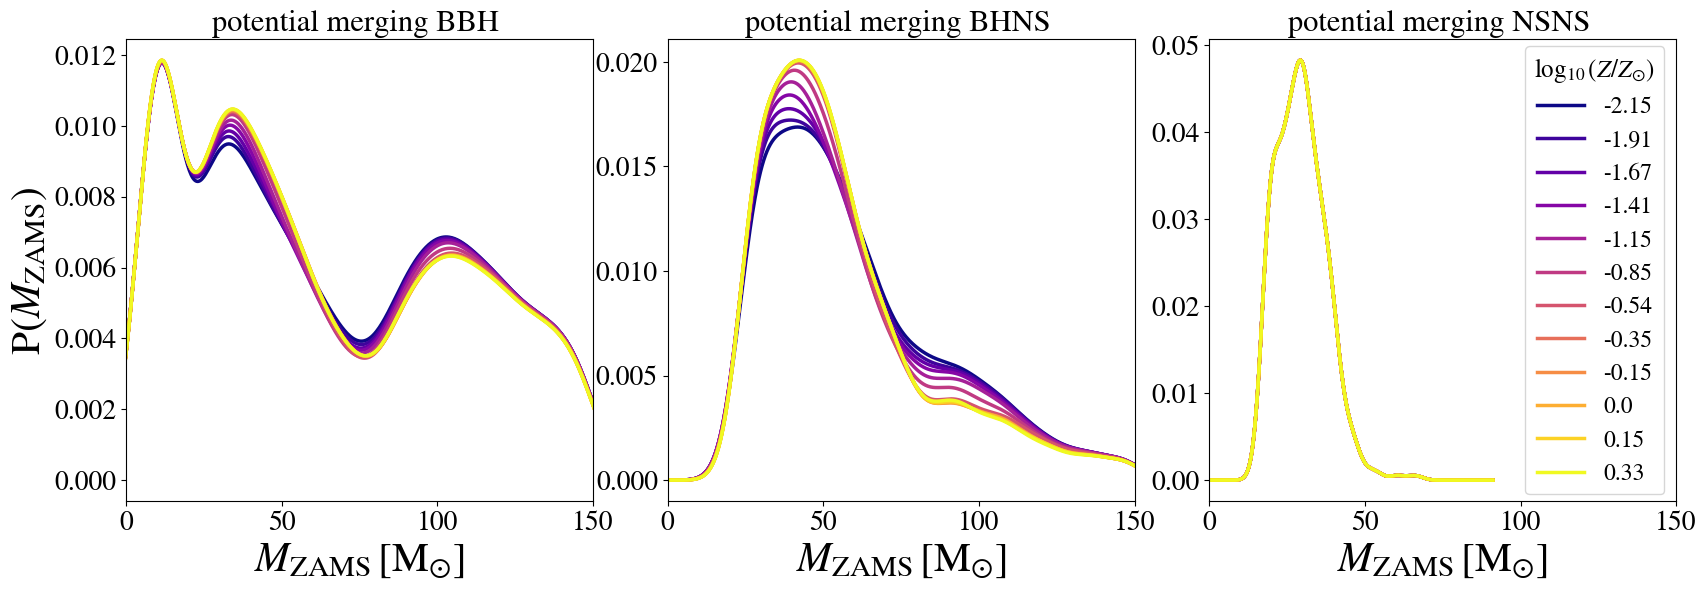

In [41]:
# get a list of colors
cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0, 1, len(potential_DCO_progenitors['Metallicity@ZAMS(1)'].unique())) )

###########################################
# Create a figure
fig = plt.figure(figsize=(20, 6))

# Create a GridSpec with 1 row and 3 columns
gs      = GridSpec(1, 3, figure=fig)
axes    = [fig.add_subplot(gs[0, i]) for i in range(3)] # Create 3 subplots on a line

# List of panda tables of pot DCO progenitors
DCO_flavors = ["BBH", "BHNS", "NSNS"]
dfs         = [potential_DCO_progenitors, potential_BBH_progenitors, potential_BHNS_progenitors, potential_NSNS_progenitors]

# Loop over the axes and DCO flavors
for ax, flavor in zip(axes, DCO_flavors):

    print(flavor)

    # select the right dataframe
    table = dfs[DCO_flavors.index(flavor)]

    grouped_byZ = table.groupby('Metallicity@ZAMS(1)')

    # perform the KDE for each metallicity
    for i, (metal, group) in enumerate(grouped_byZ):
        group['Mass@ZAMS(1)'].plot.kde(ax=ax, label=f'{np.round(np.log10(metal/0.014), 2)}', color = colors[i], linewidth=2.5)


    ax.set_title(f'potential merging {flavor} ', fontsize = 22)

    ax.set_xlim(0,150)
    ax.set_xlabel('$M_{\mathrm{ZAMS}} \, [\mathrm{M_{\odot}}$]', fontsize = 30)
    ax.set_ylabel('')

#########################
# plotvalues
fig.subplots_adjust(hspace=0, wspace=0.16)
axes[0].set_ylabel("P($M_{\mathrm{ZAMS}}$)", fontsize =30)

axes[2].legend(bbox_to_anchor=(1, 1.01), loc='upper right', fontsize = 17, title_fontsize = 18, title = '$\log_{10}(Z/Z_{\odot})$')

plt.savefig(f'../plots/M_ZAMS_dist{sim_name}.pdf', bbox_inches='tight')
plt.show()

